# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand, min, max, desc, concat, explode
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, LinearSVC, GBTClassifier, NaiveBayes
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [3]:
from pyspark.sql.functions import col, trim, lower

In [4]:
import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

%matplotlib inline

In [5]:
! spark-shell --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 2.4.3
      /_/
                        
Using Scala version 2.11.12, OpenJDK 64-Bit Server VM, 1.8.0_265
Branch 
Compiled by user  on 2019-05-01T05:08:38Z
Revision 
Url 
Type --help for more information.


In [6]:
#set seaborn style
sns.set(style="whitegrid")

In [7]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify_local').getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [8]:
df = spark.read.json('mini_sparkify_event_data.json')

In [9]:
df.limit(10).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [10]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



- Among the fields an user's firstName and lastName are very unlikely to be linked to churn and the goal of this project is to build a model to predict churn based on certain factors. So we can drop those fields.
- An user's location may/may not influence churn and we cannot be certain at this stage. It would be interesting to find out if user's of a particular location are churning more than others due to factors we don't know.So let us keep location for now.
- 

In [11]:
for col_ in df.columns:
    print(col_,df.filter(col(col_).isNull()).count())

artist 58392
auth 0
firstName 8346
gender 8346
itemInSession 0
lastName 8346
length 58392
level 0
location 8346
method 0
page 0
registration 8346
sessionId 0
song 58392
status 0
ts 0
userAgent 8346
userId 0


In [12]:
drop_lst = ['firstName','lastName']
df = df.drop(*drop_lst) 

In [13]:
df.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



- There appears to be blank user ids

In [14]:
df.describe('sessionId').show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [15]:
df.count()

286500

In [16]:
df.columns

['artist',
 'auth',
 'gender',
 'itemInSession',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [17]:
df.dtypes

[('artist', 'string'),
 ('auth', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string')]

In [18]:
df.dropDuplicates().count()

286500

In [19]:
df.filter(col("userId") == "" ).count()

8346

In [20]:
## Clean empty user id's
df = df.filter(df.userId!="")
df.count()

278154

#### Generate stats for all columns
- We have strings, doubles and bigints. Certain stats like mean may not make sense for strings like artists. We will ignore them

In [21]:
stats_df = df.describe().toPandas().set_index("summary")
all_stats =spark.createDataFrame(stats_df.reset_index()).cache()
stats_df

,artist,auth,gender,itemInSession,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
summary,,,,,,,,,,,,,,,,
count,228108,278154,278154,278154,228108,278154,278154,278154,278154,278154,278154,228108,278154,278154,278154,278154
mean,551.0852017937219,None,None,114.89918174824018,249.1171819778458,None,None,None,None,1.5353588340844272E12,1042.5616241362698,Infinity,209.10321620397335,1.5409589154318713E12,None,59682.02278593872
stddev,1217.7693079161374,None,None,129.851729399489,99.23517921058361,None,None,None,None,3.291321616327586E9,726.5010362219813,NaN,30.151388851328214,1.5068287123306298E9,None,109091.9499991047
min,!!!,Cancelled,F,0,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",10
max,ÃÂlafur Arnalds,Logged In,M,1321,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


- auth is a field that indicates if a user managed to login or his authentication is cancelled. 
- The actual song itself cannot make it a good feature however we can think of how many different songs a user has listened.

In [22]:
df.filter( col("userId") == ""  ).count()

0

In [23]:
df.columns

['artist',
 'auth',
 'gender',
 'itemInSession',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [24]:
# Create a user defined function for formating the timestamp
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

#Apply the udf on the ts column
df = df.withColumn("act_time", get_time(df.ts))
df = df.withColumn("registration_ts", get_time(df.registration))

In [25]:
#drop_lst = ['registration','ts']
#df = df.drop(*drop_lst) 

In [26]:
df.limit(5).toPandas()

,artist,auth,gender,itemInSession,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,act_time,registration_ts
0,Martha Tilston,Logged In,M,50,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:01:57,2018-09-28 22:22:42
1,Five Iron Frenzy,Logged In,M,79,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:03:00,2018-09-30 18:20:30
2,Adam Lambert,Logged In,M,51,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:06:34,2018-09-28 22:22:42
3,Enigma,Logged In,M,80,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:06:56,2018-09-30 18:20:30
4,Daft Punk,Logged In,M,52,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:11:16,2018-09-28 22:22:42


In [27]:
df.createOrReplaceTempView("Sparkify_local_cleaned")

In [28]:
spark.sql('''
        SELECT DISTINCT(auth)
        FROM Sparkify_local_cleaned
''').show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [29]:
spark.sql('''
        SELECT auth,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned
        GROUP BY auth
        ORDER BY user_counts DESC
''').show()

+---------+-----------+
|     auth|user_counts|
+---------+-----------+
|Logged In|        225|
|Cancelled|         52|
+---------+-----------+



In [30]:
gender_count = spark.sql('''
        SELECT gender,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned
        GROUP BY gender
        ORDER BY user_counts DESC
''')
gender_count.show()

+------+-----------+
|gender|user_counts|
+------+-----------+
|     M|        121|
|     F|        104|
+------+-----------+



In [31]:
spark.sql('''
        SELECT count(*)
        FROM Sparkify_local_cleaned
        where userid != ''
''').show()

+--------+
|count(1)|
+--------+
|  278154|
+--------+



In [32]:
spark.sql('''
        SELECT count(*)
        FROM Sparkify_local_cleaned
        where userid = ''
''').show()

+--------+
|count(1)|
+--------+
|       0|
+--------+



In [33]:
spark.sql('''
        SELECT COUNT(DISTINCT(itemInSession)) AS item_counts
        FROM Sparkify_local_cleaned
''').show()

+-----------+
|item_counts|
+-----------+
|       1311|
+-----------+



In [34]:
length_data = spark.sql('''
        SELECT length
        FROM Sparkify_local_cleaned
''')

In [35]:
length_data.show(5)

+---------+
|   length|
+---------+
|277.89016|
|236.09424|
| 282.8273|
|262.71302|
|223.60771|
+---------+
only showing top 5 rows



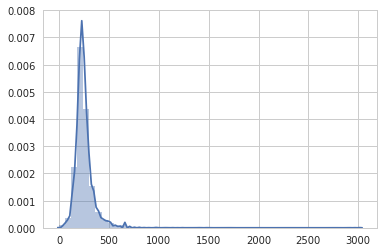

In [36]:
sns.distplot(length_data.toPandas().dropna());

In [37]:
spark.sql('''
        SELECT level,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned
        GROUP BY level
        ORDER BY user_counts DESC
''').show()

+-----+-----------+
|level|user_counts|
+-----+-----------+
| free|        195|
| paid|        165|
+-----+-----------+



In [38]:
location_count = spark.sql('''
        SELECT location,gender,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned
        GROUP BY location, gender
        ORDER BY user_counts DESC
''').toPandas()

In [39]:
#split city and state
location_count = location_count.join(location_count['location'].str.split(',',expand=True).rename(columns={0:'city',1:'state'})).drop('location',axis=1)

In [40]:
location_count.head(10)

,gender,user_counts,city,state
0,F,9,Los Angeles-Long Beach-Anaheim,CA
1,M,8,New York-Newark-Jersey City,NY-NJ-PA
2,M,7,Los Angeles-Long Beach-Anaheim,CA
3,F,7,New York-Newark-Jersey City,NY-NJ-PA
4,M,6,Dallas-Fort Worth-Arlington,TX
5,M,5,Phoenix-Mesa-Scottsdale,AZ
6,M,4,Chicago-Naperville-Elgin,IL-IN-WI
7,F,4,Boston-Cambridge-Newton,MA-NH
8,F,4,Charlotte-Concord-Gastonia,NC-SC
9,M,3,Houston-The Woodlands-Sugar Land,TX


In [41]:
top10cities = location_count.groupby('city')['user_counts'].sum().sort_values(ascending=False).head(10)

In [42]:
top10cities

city
Los Angeles-Long Beach-Anaheim           16
New York-Newark-Jersey City              15
Dallas-Fort Worth-Arlington               7
Phoenix-Mesa-Scottsdale                   7
Charlotte-Concord-Gastonia                6
St. Louis                                 6
Chicago-Naperville-Elgin                  6
Boston-Cambridge-Newton                   5
Miami-Fort Lauderdale-West Palm Beach     5
Philadelphia-Camden-Wilmington            5
Name: user_counts, dtype: int64

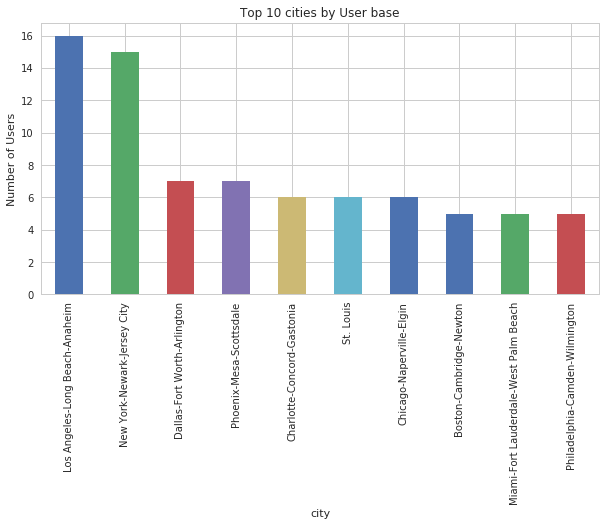

In [43]:
top10cities.plot(kind = 'bar',figsize=(10,5));
plt.title('Top 10 cities by User base')
plt.ylabel('Number of Users');

In [44]:
top10states = location_count.groupby('state')['user_counts'].sum().sort_values(ascending=False).head(10)

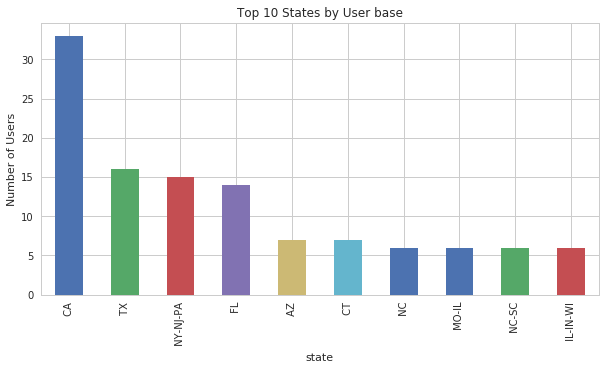

In [45]:
top10states.plot(kind='bar',figsize=(10,5));
plt.title('Top 10 States by User base')
plt.ylabel('Number of Users');

In [46]:
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [47]:
spark.sql('''
        SELECT page,COUNT(userId) AS user_counts
        FROM Sparkify_local_cleaned
        GROUP BY page
        ORDER BY user_counts DESC
''').toPandas()

,page,user_counts
0,NextSong,228108
1,Thumbs Up,12551
2,Home,10082
3,Add to Playlist,6526
4,Add Friend,4277
5,Roll Advert,3933
6,Logout,3226
7,Thumbs Down,2546
8,Downgrade,2055
9,Settings,1514


- 52 users have clearly churned based on the visit to the page Cancellation Confirmation

In [48]:
userAgent_count = spark.sql('''
        SELECT userAgent,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned
        GROUP BY userAgent
        ORDER BY user_counts DESC
''').toPandas()

In [49]:
pd.set_option('display.max_colwidth', -1)
userAgent_count.head(30)

,userAgent,user_counts
0,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",24
1,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,18
2,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36""",16
3,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",12
4,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4""",12
5,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36""",10
6,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, like Gecko) Version/7.0.6 Safari/537.78.2""",10
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:31.0) Gecko/20100101 Firefox/31.0,9
8,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",8
9,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",7


In [50]:
def get_browser(x):
    '''
    Input: A String containing User agent information
    Output: Type of User Browser or NaN
    '''
    if 'Firefox' in x:
        return 'Firefox'
    elif 'Safari' in x:
        if 'Chrome' in x:
            return 'Chrome'
        else:
            return 'Safari'
    elif 'Trident' in x:
        return 'IE'
    else:
        return np.NaN

In [51]:
userAgent_count['browser'] = userAgent_count['userAgent'].apply(get_browser)

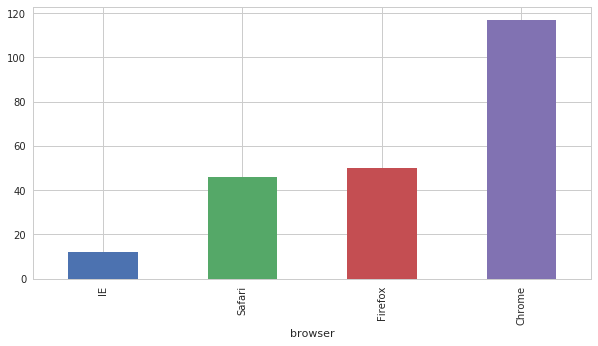

In [52]:

userAgent_count.groupby('browser')['user_counts'].sum().sort_values().plot(kind='bar' ,figsize=(10,5));

In [53]:
platform_dict = {'compatible': 'Windows',  'iPad': 'iPad',  'iPhone': 'iPhone',  
          'Macintosh': 'Mac',  'Windows NT 5.1': 'Windows','Windows NT 6.0': 'Windows', 'Windows NT 6.1': 'Windows',  
          'Windows NT 6.2': 'Windows',  'Windows NT 6.3': 'Windows', 'X11': 'Linux'}

In [54]:
userAgent_count['platform'] = userAgent_count['userAgent'].str.extract(r'\(([^\)]*)\)')[0].str.split(';').str[0].map(platform_dict)

In [55]:
userAgent_count.shape

(56, 4)

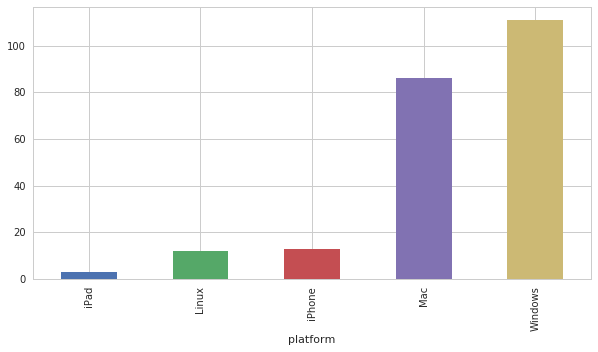

In [56]:
userAgent_count.groupby('platform')['user_counts'].sum().sort_values().plot(kind='bar',figsize=(10,5));


In [57]:
time_data = spark.sql('''
        SELECT act_time,userId
        FROM Sparkify_local_cleaned
''').toPandas()

In [58]:
time_data['act_time'] = pd.to_datetime(time_data['act_time'])

In [59]:
weekday_dict = {0:'Mon.',1:'Tues.',2:'Wed.',3:'Thur.',4:'Fri.',5:'Sat.',6:'Sun.'}
time_data['dayofweek'] = time_data['act_time'].dt.weekday.map(weekday_dict)
time_data['day'] = time_data['act_time'].dt.day
time_data['hour'] = time_data['act_time'].dt.hour

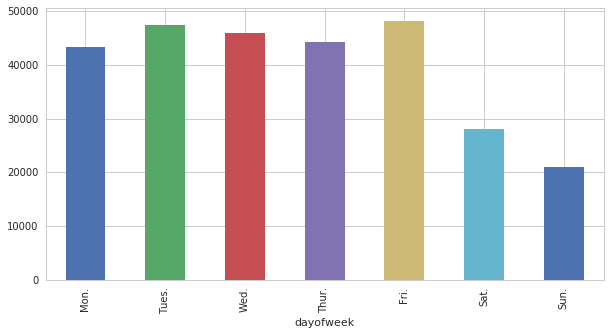

In [60]:
time_data.groupby('dayofweek')['userId'].count().loc[list(weekday_dict.values())].plot(kind='bar',figsize=(10,5));

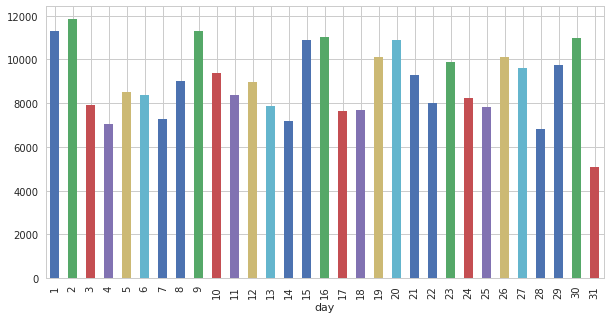

In [61]:
time_data.groupby('day')['userId'].count().plot(kind='bar' , figsize=(10,5));

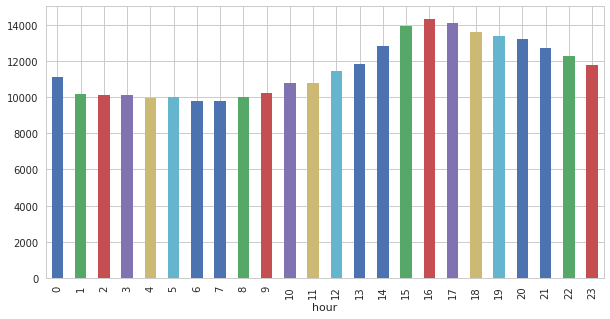

In [62]:
time_data.groupby('hour')['userId'].count().plot(kind='bar' ,figsize=(10,5));

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [63]:
#define an udf to transform event to 0 or 1
flag_event = udf(lambda x : 1 if x=='Cancellation Confirmation' else 0, IntegerType())

In [64]:
#define the current churn or not state
df_cleaned_cancel = df.withColumn('Churn_state',flag_event('page'))

In [65]:
df_cleaned_cancel.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [66]:
df_cleaned_cancel.filter(df_cleaned_cancel.page=="Cancellation Confirmation").select("userId").dropDuplicates().show(10)

+------+
|userId|
+------+
|   125|
|    51|
|    54|
|100014|
|   101|
|    29|
|100021|
|    87|
|    73|
|     3|
+------+
only showing top 10 rows



In [67]:
df_cleaned_cancel.columns

['artist',
 'auth',
 'gender',
 'itemInSession',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'act_time',
 'registration_ts',
 'Churn_state']

In [68]:
df_cleaned_cancel.select(["userId", "page", "act_time", "level", "song", "sessionId"]).where(df_cleaned_cancel.userId == "125").sort("act_time").show(20)

+------+--------------------+-------------------+-----+--------------------+---------+
|userId|                page|           act_time|level|                song|sessionId|
+------+--------------------+-------------------+-----+--------------------+---------+
|   125|            NextSong|2018-10-12 04:05:44| free|    paranoid android|      174|
|   125|            NextSong|2018-10-12 04:11:21| free|Hypnotize(Album V...|      174|
|   125|            NextSong|2018-10-12 04:15:11| free|       I'm On My Way|      174|
|   125|            NextSong|2018-10-12 04:18:34| free|Leader Of Men (Al...|      174|
|   125|            NextSong|2018-10-12 04:22:04| free|       Love You Down|      174|
|   125|            NextSong|2018-10-12 04:28:35| free|Don't Leave Me Be...|      174|
|   125|            NextSong|2018-10-12 04:32:08| free|     They're Red Hot|      174|
|   125|            NextSong|2018-10-12 04:35:06| free|                Kota|      174|
|   125|         Roll Advert|2018-10-12 04:

In [69]:
#mark the user who have churned event
userwindow = Window.partitionBy('userId').rangeBetween(Window.unboundedPreceding,Window.unboundedFollowing)
df_cleaned_cancel = df_cleaned_cancel.withColumn('Churn',fmax('Churn_state').over(userwindow))

In [70]:
df_cleaned_cancel.limit(5).toPandas()

,artist,auth,gender,itemInSession,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,act_time,registration_ts,Churn_state,Churn
0,Sleeping With Sirens,Logged In,F,0,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Captain Tyin Knots VS Mr Walkway (No Way),200,1539003534000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,2018-10-08 12:58:54,2018-09-27 02:45:40,0,0
1,Francesca Battistelli,Logged In,F,1,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Beautiful_ Beautiful (Album),200,1539003736000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,2018-10-08 13:02:16,2018-09-27 02:45:40,0,0
2,Brutha,Logged In,F,2,263.13098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,She's Gone,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,2018-10-08 13:05:32,2018-09-27 02:45:40,0,0
3,None,Logged In,F,3,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,Thumbs Up,1538016340000,31,None,307,1539003933000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,2018-10-08 13:05:33,2018-09-27 02:45:40,0,0
4,Josh Ritter,Logged In,F,4,316.23791,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Folk Bloodbath,200,1539004195000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,2018-10-08 13:09:55,2018-09-27 02:45:40,0,0


In [71]:
df_cleaned_cancel.dropDuplicates(['userId']).select('Churn').groupby('Churn').count().collect()

[Row(Churn=1, count=52), Row(Churn=0, count=173)]

In [72]:
df_cleaned_cancel.dropDuplicates(["userId"]).groupby(["Churn", "auth"]).count().sort("Churn").show()

+-----+---------+-----+
|Churn|     auth|count|
+-----+---------+-----+
|    0|Logged In|  173|
|    1|Logged In|   52|
+-----+---------+-----+



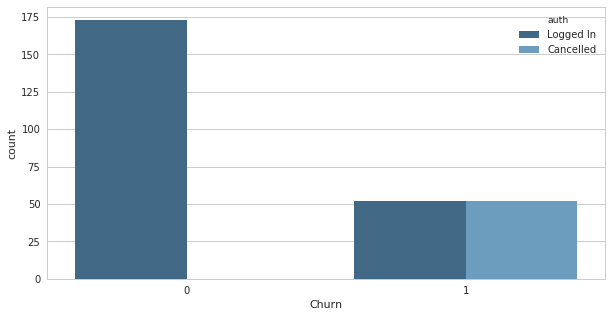

In [73]:
fig_dims = (10, 5)
fig, ax = plt.subplots(figsize=fig_dims)
df_pd = df_cleaned_cancel.dropDuplicates(["userId", "auth"]).groupby(["Churn", "auth"]).count().sort("Churn").toPandas()
sns.barplot(x='Churn', y='count', hue='auth', ax=ax, data=df_pd, palette="Blues_d");

- auth has no bearing on churn, It can be dropped

In [74]:
df_cleaned_cancel.dropDuplicates(["userId", "gender"]).groupby(["Churn", "gender"]).count().sort("Churn").show()

+-----+------+-----+
|Churn|gender|count|
+-----+------+-----+
|    0|     M|   89|
|    0|     F|   84|
|    1|     F|   20|
|    1|     M|   32|
+-----+------+-----+



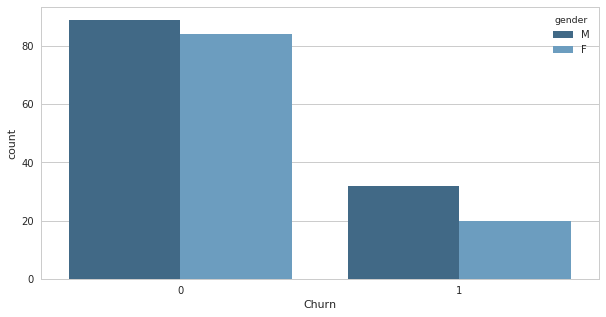

In [75]:
fig_dims = (10, 5)
fig, ax = plt.subplots(figsize=fig_dims)
df_pd = df_cleaned_cancel.dropDuplicates(["userId", "gender"]).groupby(["Churn", "gender"]).count().sort("Churn").toPandas()
sns.barplot(x='Churn', y='count', hue='gender', ax = ax, data=df_pd, palette="Blues_d");

In [76]:
proportions_ztest([32,20],[121,104],alternative='two-sided')

(1.2800974409737422, 0.20051086855629463)

In [77]:
df_cleaned_cancel.select(["Churn", "length"]).groupby(["Churn"]).agg(avg('length').alias('mean_length'), 
                                                                     stddev('length').alias('stdev_length'),
                                                                    fmax('length').alias('max_length'),
                                                                    fmin('length').alias('min_length')).show()

+-----+------------------+------------------+----------+----------+
|Churn|       mean_length|      stdev_length|max_length|min_length|
+-----+------------------+------------------+----------+----------+
|    1|248.63279564406218|102.38497717575477|3024.66567|   4.04853|
|    0|249.20913538880816|  98.6258830014688|3024.66567|   0.78322|
+-----+------------------+------------------+----------+----------+



In [78]:
df_cleaned_cancel.dropDuplicates(["userId"]).groupby(["Churn", "level"]).count().sort("Churn").show()

+-----+-----+-----+
|Churn|level|count|
+-----+-----+-----+
|    0| free|  133|
|    0| paid|   40|
|    1| paid|    8|
|    1| free|   44|
+-----+-----+-----+



In [79]:
proportions_ztest([8,44],[48,177],alternative='two-sided')

(-1.194176507959015, 0.23240893045643263)

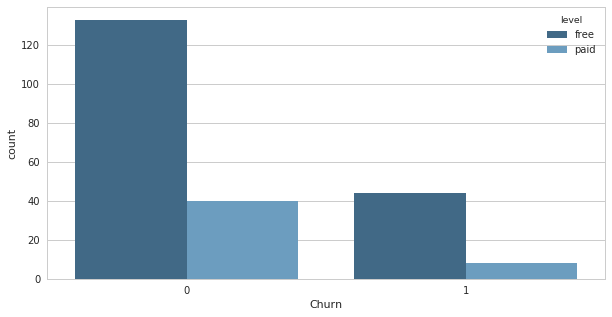

In [80]:
fig_dims = (10, 5)
fig, ax = plt.subplots(figsize=fig_dims)
df_pd = df_cleaned_cancel.dropDuplicates(["userId", "gender"]).groupby(["Churn", "level"]).count().sort("Churn").toPandas()
sns.barplot(x='Churn', y='count', hue='level', ax = ax, data=df_pd, palette="Blues_d");

In [81]:
df_cleaned_cancel.limit(5).toPandas()

,artist,auth,gender,itemInSession,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,act_time,registration_ts,Churn_state,Churn
0,Sleeping With Sirens,Logged In,F,0,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Captain Tyin Knots VS Mr Walkway (No Way),200,1539003534000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,2018-10-08 12:58:54,2018-09-27 02:45:40,0,0
1,Francesca Battistelli,Logged In,F,1,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Beautiful_ Beautiful (Album),200,1539003736000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,2018-10-08 13:02:16,2018-09-27 02:45:40,0,0
2,Brutha,Logged In,F,2,263.13098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,She's Gone,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,2018-10-08 13:05:32,2018-09-27 02:45:40,0,0
3,None,Logged In,F,3,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,Thumbs Up,1538016340000,31,None,307,1539003933000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,2018-10-08 13:05:33,2018-09-27 02:45:40,0,0
4,Josh Ritter,Logged In,F,4,316.23791,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Folk Bloodbath,200,1539004195000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,2018-10-08 13:09:55,2018-09-27 02:45:40,0,0


### Normalize Data:

- Normalization is a technique often applied as part of data preparation for machine learning. The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values. 
- For machine learning, every dataset does not require normalization. It is required only when features have different ranges.



In [82]:
def normalize_data(groupby_data):
    '''
    Input: dataframe with columns
    Output: Returns a dataframe with an additional column result with a normalised values between 0 and 1.0
    '''
    groupby_series = groupby_data.set_index(list(groupby_data.columns[:2]))
    temp = groupby_series.unstack('Churn').fillna(0)
    df = pd.DataFrame(((temp - temp.min()) / (temp.max() - temp.min())).stack()).reset_index()
    df = df.rename(columns={df.columns[-1]:'result'})
    return df

In [83]:
split_city_state = split(df_cleaned_cancel['location'], ',')
df_cleaned_cancel = df_cleaned_cancel.withColumn('city',split_city_state.getItem(0))
df_cleaned_cancel = df_cleaned_cancel.withColumn('state',split_city_state.getItem(1))

In [84]:
city_data = df_cleaned_cancel.dropDuplicates(["userId"]).groupby(["city","Churn"]).count().sort("city").toPandas()

In [85]:
city_data.shape

(133, 3)

In [86]:
city_data.head()

,city,Churn,count
0,Albany,1,1
1,Albany-Schenectady-Troy,1,1
2,Alexandria,0,1
3,Allentown-Bethlehem-Easton,0,1
4,Anchorage,0,1


In [87]:
city_data[city_data['city']=='Albany']

,city,Churn,count
0,Albany,1,1


In [88]:
city_data[city_data['city']=='Los Angeles-Long Beach-Anaheim']

,city,Churn,count
65,Los Angeles-Long Beach-Anaheim,0,13
66,Los Angeles-Long Beach-Anaheim,1,3


In [89]:
city_data[city_data['city']=='New York-Newark-Jersey City']

,city,Churn,count
83,New York-Newark-Jersey City,0,10
84,New York-Newark-Jersey City,1,5


In [90]:
city_data = normalize_data(city_data)

In [91]:
city_data[city_data['city']=='Albany']

,city,Churn,result
0,Albany,0,0.0
1,Albany,1,0.2


In [92]:
city_data[city_data['city']=='Los Angeles-Long Beach-Anaheim']

,city,Churn,result
110,Los Angeles-Long Beach-Anaheim,0,1.0
111,Los Angeles-Long Beach-Anaheim,1,0.6


In [93]:
city_data[city_data['city']=='New York-Newark-Jersey City']

,city,Churn,result
142,New York-Newark-Jersey City,0,0.769231
143,New York-Newark-Jersey City,1,1.000000


In [94]:
city_data.head()

,city,Churn,result
0,Albany,0,0.000000
1,Albany,1,0.200000
2,Albany-Schenectady-Troy,0,0.000000
3,Albany-Schenectady-Troy,1,0.200000
4,Alexandria,0,0.076923


In [95]:
city_data.shape

(226, 3)

In [96]:
city_data.columns

Index(['city', 'Churn', 'result'], dtype='object')

In [97]:
city_data['result'].max()

1.0

In [98]:
city_data.loc[city_data['result'] >= 1]

,city,Churn,result
110,Los Angeles-Long Beach-Anaheim,0,1.0
143,New York-Newark-Jersey City,1,1.0


In [99]:
city_data['result'].min()

0.0

In [100]:
city_data.loc[city_data['result'] == 0]

,city,Churn,result
0,Albany,0,0.0
2,Albany-Schenectady-Troy,0,0.0
5,Alexandria,1,0.0
7,Allentown-Bethlehem-Easton,1,0.0
9,Anchorage,1,0.0
11,Atlanta-Sandy Springs-Roswell,1,0.0
13,Atlantic City-Hammonton,1,0.0
15,Austin-Round Rock,1,0.0
17,Bakersfield,1,0.0
21,Billings,1,0.0


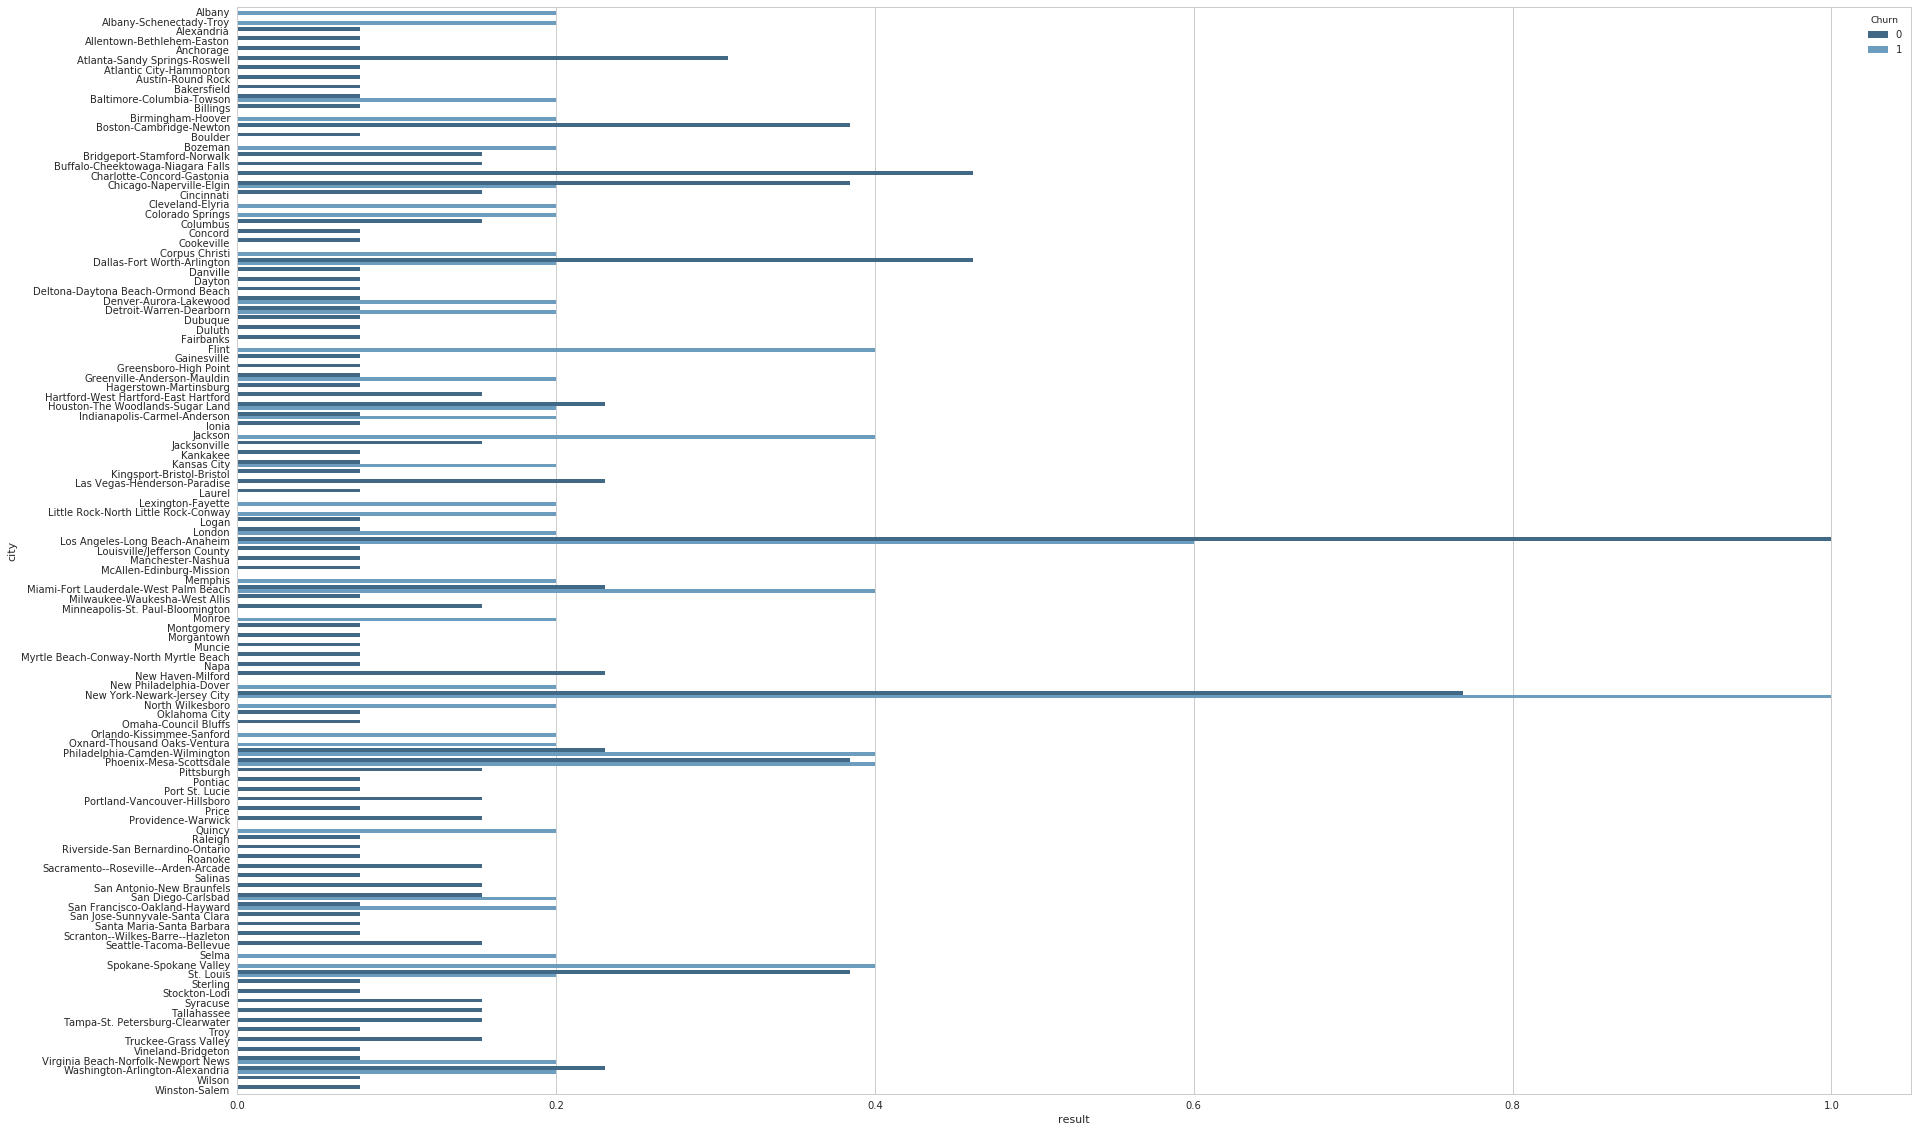

In [101]:
fig_dims = (30, 20)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot( x="result",y="city", hue="Churn", data=city_data,ax=ax,  palette="Blues_d");

In [102]:
state_data = df_cleaned_cancel.dropDuplicates(["userId"]).groupby(["state","Churn"]).count().sort("state").toPandas()

In [103]:
state_data = normalize_data(state_data)

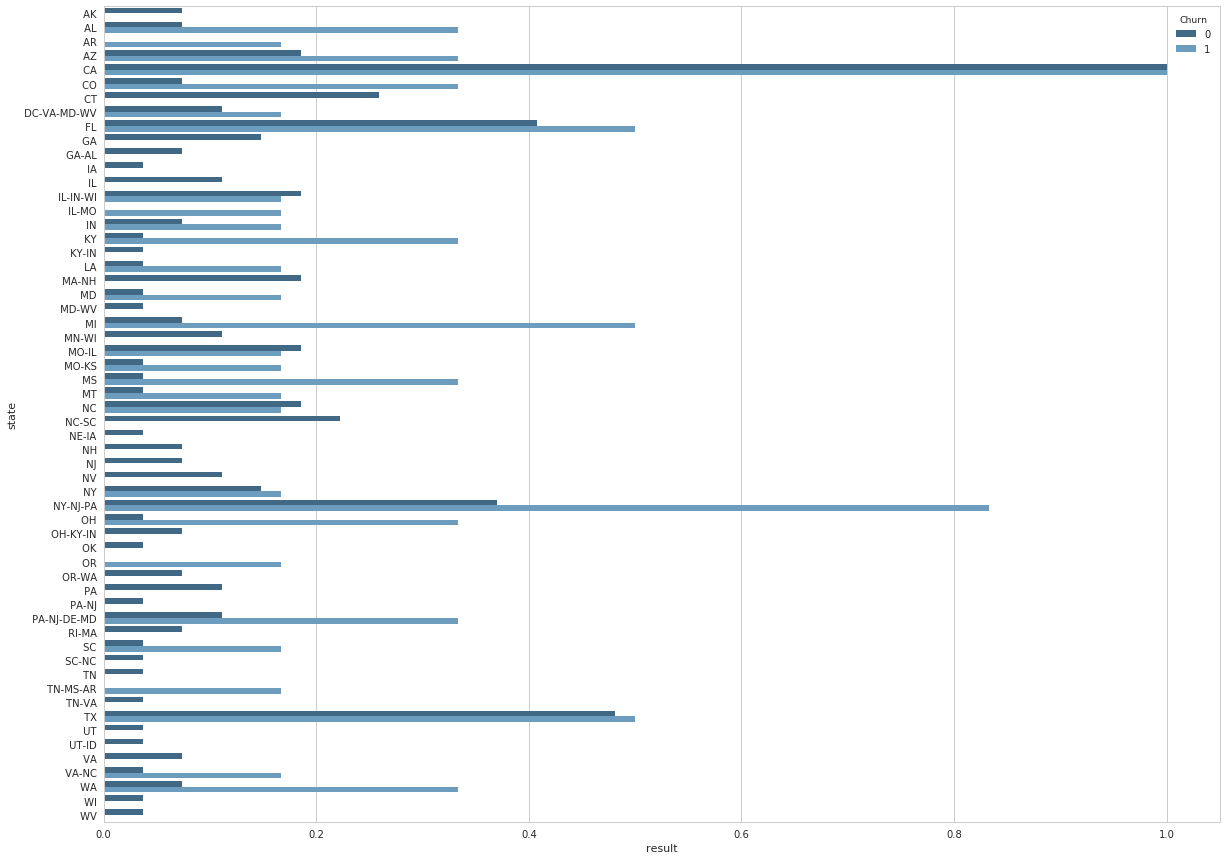

In [104]:
fig, ax = plt.subplots(figsize=(20,15))
sns.barplot( x="result",y="state", hue="Churn", data=state_data,ax=ax, palette="Blues_d");

In [105]:
df_cleaned_cancel.select(["Churn", "page"]).groupby(["Churn", "page"]).count().sort("page").show()

+-----+--------------------+------+
|Churn|                page| count|
+-----+--------------------+------+
|    1|               About|    56|
|    0|               About|   439|
|    1|          Add Friend|   636|
|    0|          Add Friend|  3641|
|    1|     Add to Playlist|  1038|
|    0|     Add to Playlist|  5488|
|    1|              Cancel|    52|
|    1|Cancellation Conf...|    52|
|    0|           Downgrade|  1718|
|    1|           Downgrade|   337|
|    0|               Error|   220|
|    1|               Error|    32|
|    0|                Help|  1215|
|    1|                Help|   239|
|    0|                Home|  8410|
|    1|                Home|  1672|
|    1|              Logout|   553|
|    0|              Logout|  2673|
|    1|            NextSong| 36394|
|    0|            NextSong|191714|
+-----+--------------------+------+
only showing top 20 rows



In [106]:
page_data = df_cleaned_cancel.select(["page","Churn"]).groupby([ "page","Churn"]).count().sort("page").toPandas()

In [107]:
page_data = normalize_data(page_data)

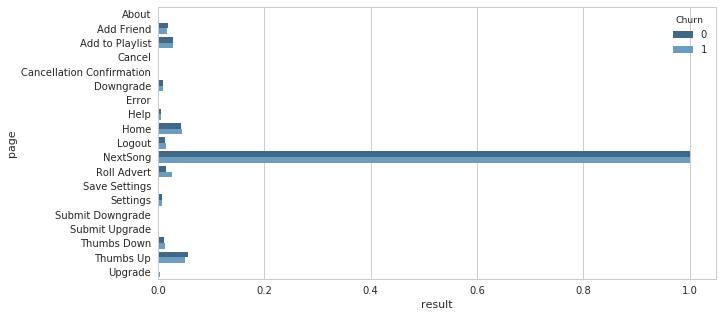

In [108]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot( x="result",y="page", hue="Churn", data=page_data,ax=ax,palette="Blues_d");

In [109]:
browser = udf(lambda x : get_browser(x))

In [110]:
#get browsers
df_cleaned_cancel = df_cleaned_cancel.withColumn('browser',browser(df_cleaned_cancel.userAgent))

In [111]:
get_platform = udf(lambda x: platform_dict[re.findall(r'\(([^\)]*)\)',x)[0].split(';')[0]])

In [112]:
#get platform
df_cleaned_cancel = df_cleaned_cancel.withColumn('platform',get_platform(df_cleaned_cancel.userAgent))

In [113]:
browser_data = df_cleaned_cancel.select(["browser","Churn"]).groupby([ "browser","Churn"]).count().sort("browser").toPandas()

In [114]:
browser_data = normalize_data(browser_data)

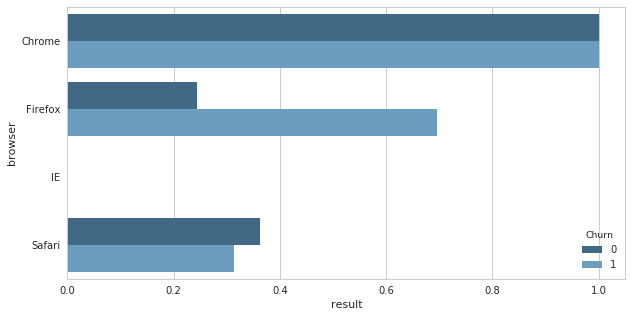

In [115]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot( x="result",y="browser", hue="Churn", data=browser_data,ax=ax, palette="Blues_d");

In [116]:
platform_data = df_cleaned_cancel.select(["platform","Churn"]).groupby([ "platform","Churn"]).count().sort("platform").toPandas()

In [117]:
platform_data = normalize_data(platform_data)

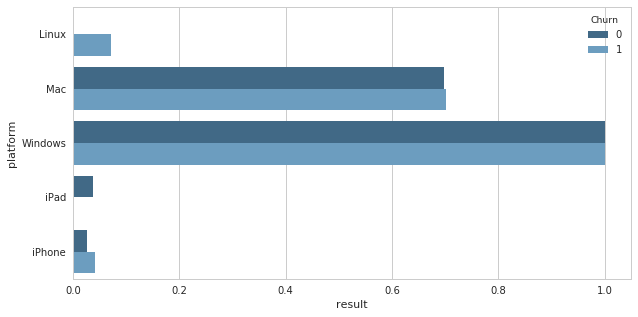

In [118]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot( x="result",y="platform", hue="Churn", data=platform_data,ax=ax, palette="Blues_d");

In [119]:
df_cleaned_cancel.limit(5).toPandas()

,artist,auth,gender,itemInSession,length,level,location,method,page,registration,...,userAgent,userId,act_time,registration_ts,Churn_state,Churn,city,state,browser,platform
0,Sleeping With Sirens,Logged In,F,0,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,...,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,2018-10-08 12:58:54,2018-09-27 02:45:40,0,0,Bridgeport-Stamford-Norwalk,CT,Safari,iPhone
1,Francesca Battistelli,Logged In,F,1,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,...,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,2018-10-08 13:02:16,2018-09-27 02:45:40,0,0,Bridgeport-Stamford-Norwalk,CT,Safari,iPhone
2,Brutha,Logged In,F,2,263.13098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,...,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,2018-10-08 13:05:32,2018-09-27 02:45:40,0,0,Bridgeport-Stamford-Norwalk,CT,Safari,iPhone
3,None,Logged In,F,3,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,Thumbs Up,1538016340000,...,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,2018-10-08 13:05:33,2018-09-27 02:45:40,0,0,Bridgeport-Stamford-Norwalk,CT,Safari,iPhone
4,Josh Ritter,Logged In,F,4,316.23791,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,...,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,2018-10-08 13:09:55,2018-09-27 02:45:40,0,0,Bridgeport-Stamford-Norwalk,CT,Safari,iPhone


In [120]:
df_cleaned_cancel_kbp = df_cleaned_cancel

In [121]:
df_cleaned_cancel_kbp.limit(2).toPandas()

,artist,auth,gender,itemInSession,length,level,location,method,page,registration,...,userAgent,userId,act_time,registration_ts,Churn_state,Churn,city,state,browser,platform
0,Sleeping With Sirens,Logged In,F,0,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,...,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,2018-10-08 12:58:54,2018-09-27 02:45:40,0,0,Bridgeport-Stamford-Norwalk,CT,Safari,iPhone
1,Francesca Battistelli,Logged In,F,1,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,...,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,2018-10-08 13:02:16,2018-09-27 02:45:40,0,0,Bridgeport-Stamford-Norwalk,CT,Safari,iPhone


In [122]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))

In [123]:
df_cleaned_cancel = df_cleaned_cancel_kbp
df_cleaned_cancel.limit(2).toPandas()

,artist,auth,gender,itemInSession,length,level,location,method,page,registration,...,userAgent,userId,act_time,registration_ts,Churn_state,Churn,city,state,browser,platform
0,Sleeping With Sirens,Logged In,F,0,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,...,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,2018-10-08 12:58:54,2018-09-27 02:45:40,0,0,Bridgeport-Stamford-Norwalk,CT,Safari,iPhone
1,Francesca Battistelli,Logged In,F,1,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,...,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,2018-10-08 13:02:16,2018-09-27 02:45:40,0,0,Bridgeport-Stamford-Norwalk,CT,Safari,iPhone


In [124]:
df_cleaned_cancel = df_cleaned_cancel.withColumn('hour', get_hour(df_cleaned_cancel.ts))
df_cleaned_cancel = df_cleaned_cancel.withColumn('day', get_day(df_cleaned_cancel.ts))
df_cleaned_cancel = df_cleaned_cancel.withColumn('dayofweek', get_weekday(df_cleaned_cancel.ts))

In [125]:
hour_data = df_cleaned_cancel.select(["Churn", "hour"]).groupby(["Churn", "hour"]).count().sort("hour").toPandas()
day_data = df_cleaned_cancel.select(["Churn", "day"]).groupby(["Churn", "day"]).count().sort("day").toPandas()
dayofweek_data = df_cleaned_cancel.select(["Churn", "dayofweek"]).groupby(["Churn", "dayofweek"]).count().sort("dayofweek").toPandas()

In [126]:
hour_data = normalize_data(hour_data)

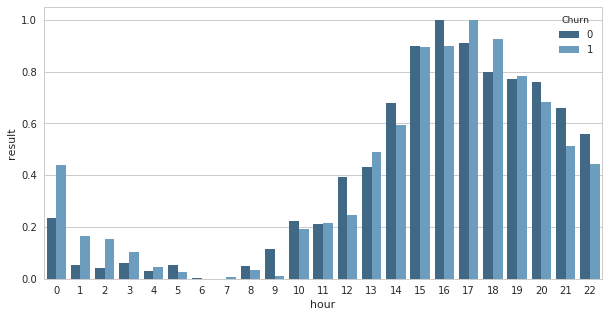

In [127]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot( x="hour",y="result", hue="Churn", data=hour_data,ax=ax,order=list(map(lambda x: str(x),range(23))), palette="Blues_d");

In [128]:
day_data = normalize_data(day_data)

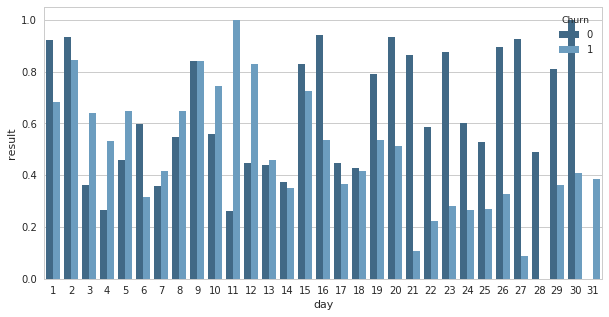

In [129]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot( x="day",y="result", hue="Churn", data=day_data,ax=ax,order=list(map(lambda x: str(x),range(1,32))), palette="Blues_d" );

In [130]:
dayofweek_data = normalize_data(dayofweek_data)

In [131]:
dayofweek_data

,dayofweek,Churn,result
0,0,0,0.000000
1,0,1,0.000000
2,1,0,0.827431
3,1,1,0.784776
4,2,0,0.985619
5,2,1,0.911285
6,3,0,0.938009
7,3,1,0.845103
8,4,0,0.842789
9,4,1,0.915720


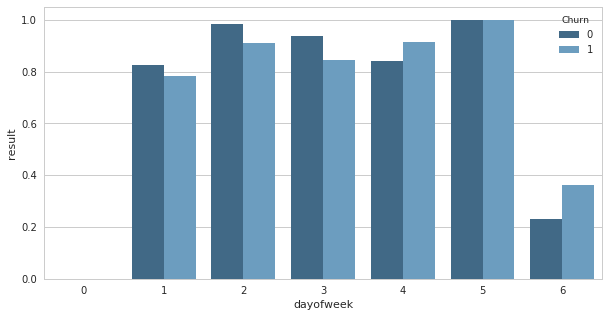

In [132]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot( x="dayofweek",y="result", hue="Churn", data=dayofweek_data,ax=ax, palette="Blues_d");

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [133]:
df_cleaned_cancel.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- act_time: string (nullable = true)
 |-- registration_ts: string (nullable = true)
 |-- Churn_state: integer (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- browser: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- day: string (nullable = t

On the basis of the above EDA, we can create features as follows:

- Categorical Features (need label encoding)
    - gender
    - level
    - browser
    - platform
    
- Numerical Features
    - mean,max,min,std of length of users
    - numbers of these item in page (NextSong,ThumbsUp, ThumbsDown, AddtoPlaylist, AddFriend, RollAdvert)
    - number of unique songs and total songs of users
    - number of unique artists of users
    - percentage of operations after 15th in a month
    - percentage of operations in workday

In [134]:
def label_encoding(col_name):
    '''
    encodes categorical data to numbers
    Input: column to be encoded
    Output:
        A dataframe consisting of the field userId and the input columns now encoded   
    '''
    temp = df_cleaned_cancel.select([col_name]).dropDuplicates().toPandas()
    label_dict = {val:str(idx) for idx,val in enumerate(temp[col_name].tolist())}
    result = df_cleaned_cancel.dropDuplicates(['userId']).select(['userId',col_name]).replace(label_dict,subset=col_name)
    return result

In [135]:
feature_gender = label_encoding('gender')
feature_gender.show(5)

+------+------+
|userId|gender|
+------+------+
|100010|     0|
|200002|     1|
|   125|     1|
|   124|     0|
|    51|     1|
+------+------+
only showing top 5 rows



In [136]:
df_cleaned_cancel.select("userId","gender").where(df_cleaned_cancel.userId == '100010').dropDuplicates().show(5)

+------+------+
|userId|gender|
+------+------+
|100010|     F|
+------+------+



In [137]:
df_cleaned_cancel.select("userId","gender").where(df_cleaned_cancel.userId == '200002').dropDuplicates().show(5)

+------+------+
|userId|gender|
+------+------+
|200002|     M|
+------+------+



In [138]:
usersample=["124","125","51"]  
df_cleaned_cancel.select("userId","gender").filter(df_cleaned_cancel.userId.isin(usersample) ).dropDuplicates().show(5)

+------+------+
|userId|gender|
+------+------+
|    51|     M|
|   125|     M|
|   124|     F|
+------+------+



In [139]:
feature_gender.select("userId","gender").filter(feature_gender.userId.isin(usersample)).dropDuplicates().show(5)

+------+------+
|userId|gender|
+------+------+
|   125|     1|
|   124|     0|
|    51|     1|
+------+------+



In [140]:
type(feature_gender)

pyspark.sql.dataframe.DataFrame

In [141]:
def get_categorical_features():
    '''
    join all categorical features together
    '''
    feature_gender = label_encoding('gender')
    feature_level = label_encoding('level')
    feature_browser = label_encoding('browser')
    feature_platform = label_encoding('platform')
    
    result = feature_gender.join(feature_level,on='userId',how='inner').\
                            join(feature_browser,on='userId',how='inner').\
                            join(feature_platform,on='userId',how='inner')
    return result

In [142]:
categorical_feature = get_categorical_features()

In [143]:
categorical_feature.show(2)

+------+------+-----+-------+--------+
|userId|gender|level|browser|platform|
+------+------+-----+-------+--------+
|100010|     0|    0|      1|       1|
|200002|     1|    0|      1|       1|
+------+------+-----+-------+--------+
only showing top 2 rows



In [144]:
categorical_feature.select("level","gender", "browser" , "platform" ).dropDuplicates().show(30)

+-----+------+-------+--------+
|level|gender|browser|platform|
+-----+------+-------+--------+
|    0|     1|      0|       4|
|    0|     1|      3|       2|
|    0|     0|      1|       3|
|    0|     1|      1|       1|
|    0|     0|      1|       0|
|    0|     1|      1|       0|
|    1|     0|      2|       4|
|    1|     1|      3|       2|
|    0|     0|      0|       4|
|    0|     0|      0|       2|
|    0|     0|      0|       3|
|    1|     1|      3|       3|
|    0|     0|      1|       1|
|    0|     1|      3|       4|
|    1|     1|      3|       4|
|    0|     0|      3|       3|
|    1|     0|      3|       2|
|    0|     1|      1|       3|
|    1|     1|      0|       4|
|    1|     0|      3|       3|
|    0|     0|      3|       4|
|    1|     0|      1|       1|
|    1|     0|      3|       4|
|    1|     0|      1|       3|
|    1|     0|      0|       4|
|    0|     1|      0|       2|
|    1|     1|      0|       3|
|    1|     0|      0|       3|
|    0| 

In [145]:
dfx = df_cleaned_cancel.select(["userId","page"]).groupby(["userId","page"]).count()
dfx.show(20)

+------+---------------+-----+
|userId|           page|count|
+------+---------------+-----+
|    88|           Home|   85|
|    88|       NextSong| 2045|
|    13|Add to Playlist|   37|
|    87|           Home|   56|
|   131|        Upgrade|    1|
|    59|     Add Friend|   16|
|    40|           Help|    9|
|    92|       Settings|   52|
|    12|      Thumbs Up|   42|
|    50|          Error|    2|
|    81|        Upgrade|    1|
|    81| Submit Upgrade|    1|
|    53| Submit Upgrade|    1|
|    99|      Downgrade|    2|
|200017|       NextSong|  493|
|300015|     Add Friend|   47|
|300007|    Roll Advert|    2|
|300005|      Thumbs Up|   35|
|300014|      Downgrade|    3|
|300019|        Upgrade|    1|
+------+---------------+-----+
only showing top 20 rows



In [146]:
page_count = df_cleaned_cancel.select(["userId","page"]).groupby(["userId","page"]).count()
# create the pivot table

In [147]:
temp1 = page_count.groupby('userId').pivot('page').agg(first('count')).fillna(0)
temp1.show(3)
 

+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|userId|About|Add Friend|Add to Playlist|Cancel|Cancellation Confirmation|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|
+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|200002|    3|         4|              8|     0|                        0|        5|    0|   2|  20|     5|     387|          7|            0|       3|               0|             1|          6|       21|      2|
|100010|    1|         4|              7|     0|                        0|        0|    0|   2|  11|     5|     275|         52|            0|  

In [148]:
temp1 = temp1.select(['userId','NextSong','Thumbs Up', 'Thumbs Down', 'Add to Playlist', 'Add Friend', 'Roll Advert'])
    # column names used to sum up for total
temp1.show()

+------+--------+---------+-----------+---------------+----------+-----------+
|userId|NextSong|Thumbs Up|Thumbs Down|Add to Playlist|Add Friend|Roll Advert|
+------+--------+---------+-----------+---------------+----------+-----------+
|200002|     387|       21|          6|              8|         4|          7|
|100010|     275|       17|          5|              7|         4|         52|
|   125|       8|        0|          0|              0|         0|          1|
|    51|    2111|      100|         21|             52|        28|          0|
|   124|    4079|      171|         41|            118|        74|          4|
|     7|     150|        7|          1|              5|         1|         16|
|    54|    2841|      163|         29|             72|        33|         47|
|    15|    1914|       81|         14|             59|        31|          1|
|   155|     820|       58|          3|             24|        11|          8|
|   132|    1928|       96|         17|             

In [149]:
cols = temp1.columns[1:]
cols

['NextSong',
 'Thumbs Up',
 'Thumbs Down',
 'Add to Playlist',
 'Add Friend',
 'Roll Advert']

In [150]:
temp1.printSchema()

root
 |-- userId: string (nullable = true)
 |-- NextSong: long (nullable = true)
 |-- Thumbs Up: long (nullable = true)
 |-- Thumbs Down: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- Add Friend: long (nullable = true)
 |-- Roll Advert: long (nullable = true)



In [151]:
from pyspark.sql.functions import col, trim, lower

In [152]:
feature_page = temp1.withColumn('total', sum([col(c) for c in cols if c != 'userId'])) 

In [153]:
feature_page.show(5)

+------+--------+---------+-----------+---------------+----------+-----------+-----+
|userId|NextSong|Thumbs Up|Thumbs Down|Add to Playlist|Add Friend|Roll Advert|total|
+------+--------+---------+-----------+---------------+----------+-----------+-----+
|200002|     387|       21|          6|              8|         4|          7|  433|
|100010|     275|       17|          5|              7|         4|         52|  360|
|   125|       8|        0|          0|              0|         0|          1|    9|
|    51|    2111|      100|         21|             52|        28|          0| 2312|
|   124|    4079|      171|         41|            118|        74|          4| 4487|
+------+--------+---------+-----------+---------------+----------+-----------+-----+
only showing top 5 rows



In [154]:
def get_numerical_features():
    '''
    join all numerical features together and implement Standscaler
    '''
    #length
    feature_length = df_cleaned_cancel.select(["userId", "length"]).groupby(["userId"]).agg(avg('length').alias('mean_length'), 
                                                                     stddev('length').alias('stdev_length'),
                                                                    fmax('length').alias('max_length'),
                                                                    fmin('length').alias('min_length'))
    
    #page, reference url:https://stackoverflow.com/questions/56051438/pivot-table-in-pyspark
    page_count = df_cleaned_cancel.select(["userId","page"]).groupby(["userId","page"]).count()
    # create the pivot table
    temp1 = page_count.groupby('userId').pivot('page').agg(first('count')).fillna(0)
    # filter columns
    temp1 = temp1.select(['userId','NextSong','Thumbs Up', 'Thumbs Down', 'Add to Playlist', 'Add Friend', 'Roll Advert'])
    # column names used to sum up for total
    cols = temp1.columns[1:]
    # calculate the total 
    feature_page = temp1.withColumn('total', sum([col(c) for c in cols]))    
    
    
    #unique songs number
    feature_nunique_song = df_cleaned_cancel.filter(df_cleaned_cancel.page=='NextSong').select(["userId","song"]).\
                                             dropDuplicates(["userId","song"]).groupby(["userId"]).count()
    feature_nunique_song = feature_nunique_song.selectExpr("userId as userId","count as nunique_song")
    
    #total songs number
    feature_ntotal_song = df_cleaned_cancel.filter(df_cleaned_cancel.page=='NextSong').select(["userId","song"]).\
                                             groupby(["userId"]).count()
    #source:https://exceptionshub.com/how-to-change-dataframe-column-names-in-pyspark.html
    feature_ntotal_song = feature_ntotal_song.selectExpr("userId as userId","count as ntotal_song")
    
    #unique artists artist
    feature_nunique_artist = df_cleaned_cancel.filter(df_cleaned_cancel.page=='NextSong').select(["userId","artist"]).\
                                               dropDuplicates(["userId","artist"]).groupby(["userId"]).count()
    feature_nunique_artist = feature_nunique_artist.selectExpr("userId as userId","count as nunique_artist")
    
    #percentage of opretions
    day_count = df_cleaned_cancel.filter(df_cleaned_cancel.day>=15).select(['userId']).groupby(["userId"]).count()
    day_count = day_count.selectExpr("userId as userId","count as day_count")
    
    total_count = df_cleaned_cancel.select(['userId']).groupby(["userId"]).count()
    total_count = total_count.selectExpr("userId as userId","count as total_count")
    
    dayofweek_count = df_cleaned_cancel.filter(df_cleaned_cancel.dayofweek<5).select(['userId']).groupby(["userId"]).count()
    dayofweek_count = dayofweek_count.selectExpr("userId as userId","count as dayofweek_count")
    
    feature_percentage_month = (total_count.alias("total").join(day_count.alias("day"), ["userId"]).\
                              select(col("userId"), (col("day.day_count") / col("total.total_count")).alias("month_percentage")))
    
    feature_percentage_week = (total_count.alias("total").join(dayofweek_count.alias("day"), ["userId"]).\
                          select(col("userId"), (col("day.dayofweek_count") / col("total.total_count")).alias("week_percentage")))
    
    #merge together
    result = feature_length.join(feature_page,on='userId',how='inner').\
                        join(feature_nunique_song,on='userId',how='inner').\
                        join(feature_ntotal_song,on='userId',how='inner').\
                        join(feature_nunique_artist,on='userId',how='inner').\
                        join(feature_percentage_month,on='userId',how='inner').\
                        join(feature_percentage_week,on='userId',how='inner')
    
    return result

In [155]:
label = df_cleaned_cancel.select(['userId','Churn']).dropDuplicates()

In [156]:
def get_data_for_train():
    '''
    merge features and label together
    '''
    categorical_feature = get_categorical_features()
    numerical_feature = get_numerical_features()
    label = df_cleaned_cancel.select(['userId','Churn']).dropDuplicates()
    result = categorical_feature.join(numerical_feature,on='userId',how='inner').join(label,on='userId',how='inner')
    
    #correct datatype
    for col_name in result.columns[1:5]:
        result = result.withColumn(col_name, result[col_name].cast(IntegerType()))
    for col_name in result.columns[5:-1]:
        result = result.withColumn(col_name, result[col_name].cast(FloatType()))
    
    #fill NaN
    result = result.na.fill(0)
    
  
    return result

In [157]:
final_data = get_data_for_train()

In [158]:
! ls

baseline.csv	     lr_model			    Sparkify-zh.ipynb
cvModel_dt1.model    mini_sparkify_event_data.json  spark-warehouse
final_data_new.json  Sparkify.ipynb		    svm_model


In [159]:
final_data.write.mode("overwrite").save('final_data_new.json',format='json',header=True)

In [160]:
final_data = spark.read.json('final_data_new.json')

In [161]:
final_data.columns

['Add Friend',
 'Add to Playlist',
 'Churn',
 'NextSong',
 'Roll Advert',
 'Thumbs Down',
 'Thumbs Up',
 'browser',
 'gender',
 'level',
 'max_length',
 'mean_length',
 'min_length',
 'month_percentage',
 'ntotal_song',
 'nunique_artist',
 'nunique_song',
 'platform',
 'stdev_length',
 'total',
 'userId',
 'week_percentage']

In [162]:
final_data_columns = final_data.columns
final_data_columns.remove('Churn')
final_data_columns.remove('userId')

In [163]:
categorical_features = ['gender','level','browser','platform']
numerical_features = [col_name for col_name in final_data_columns if col_name not in categorical_features]

In [164]:
final_data.limit(10).toPandas()

,Add Friend,Add to Playlist,Churn,NextSong,Roll Advert,Thumbs Down,Thumbs Up,browser,gender,level,...,min_length,month_percentage,ntotal_song,nunique_artist,nunique_song,platform,stdev_length,total,userId,week_percentage
0,19.0,23.0,0,942.0,86.0,11.0,35.0,2,0,0,...,34.32444,0.746988,942.0,733.0,881.0,4,93.075520,1116.0,100004,0.924498
1,23.0,43.0,0,1781.0,23.0,17.0,84.0,3,0,0,...,21.65506,0.663696,1781.0,1214.0,1571.0,4,93.417450,1971.0,104,0.848499
2,27.0,58.0,0,1644.0,3.0,9.0,84.0,0,1,0,...,27.01016,0.608205,1644.0,1137.0,1477.0,3,96.823296,1825.0,60,0.774359
3,7.0,0.0,0,29.0,4.0,0.0,2.0,3,0,0,...,15.85587,0.812500,29.0,29.0,29.0,3,88.712100,42.0,68,0.187500
4,0.0,0.0,0,37.0,3.0,0.0,0.0,3,1,0,...,22.36036,0.911111,37.0,37.0,37.0,3,116.416290,40.0,90,0.644444
5,28.0,53.0,0,1728.0,11.0,18.0,87.0,1,1,0,...,22.12526,0.677310,1728.0,1163.0,1539.0,3,86.556850,1925.0,128,0.729560
6,9.0,15.0,1,417.0,27.0,13.0,19.0,0,1,0,...,21.91628,0.641304,417.0,368.0,402.0,2,95.099785,500.0,200024,0.815217
7,15.0,21.0,0,656.0,19.0,6.0,28.0,3,0,0,...,43.80689,0.914322,656.0,553.0,624.0,4,116.713264,745.0,23,0.455243
8,36.0,61.0,0,1894.0,1.0,10.0,76.0,2,0,1,...,15.22893,0.883784,1894.0,1319.0,1699.0,4,107.104980,2078.0,41,0.586486
9,25.0,42.0,1,1073.0,14.0,9.0,52.0,3,0,0,...,33.46240,0.898473,1073.0,834.0,981.0,3,103.828865,1215.0,103,0.551145


In [165]:
# Use a VectorAssembler which is feature transformer that merges multiple columns into a single vector column.
# and Apply transform the dataset  
transvector = VectorAssembler(inputCols=numerical_features, outputCol='numerical_features', handleInvalid="skip").transform(final_data)

#implement StandardScaler which Standardizes features by removing the mean and scaling to unit variance using column summary statistics on the samples in the training set.
scaler = StandardScaler(withMean=True, withStd=True, inputCol='numerical_features', outputCol='features_scaled')
scaler_fit = scaler.fit(transvector)
result_scaled = scaler_fit.transform(transvector)


In [166]:
#add categorical features to feature vector

vector = VectorAssembler(inputCols=categorical_features+['features_scaled'], outputCol='all_features', handleInvalid="skip")
result_scaled = vector.transform(result_scaled)
final_result = result_scaled.select(result_scaled.Churn.alias('label'), result_scaled.all_features.alias('features'))

In [167]:
final_result.columns

['label', 'features']

In [168]:
final_result.persist()

DataFrame[label: bigint, features: vector]

In [169]:
final_result.limit(10).toPandas()

,label,features
0,0,"[0.0, 0.0, 2.0, 4.0, -0.0726957036435, -0.253095777862, -0.13965912114, 3.03167597445, -0.0971160730357, -0.382011734467, 0.265604069396, -0.64198997997, -0.0529945477713, 0.767228233713, -0.13965912114, -0.0303248520517, -0.100031438306, -0.171400774472, -0.100568920655, 0.986858829634]"
1,0,"[0.0, 0.0, 3.0, 4.0, 0.118042862829, 0.346573660975, 0.606905203237, 0.189935793308, 0.353149356494, 0.350782220193, 0.265604069396, -0.202978248239, -0.487435097122, 0.406541236853, 0.606905203237, 0.764863759044, 0.660908102115, -0.151075331133, 0.578928702458, 0.625321644318]"
2,0,"[1.0, 0.0, 0.0, 3.0, 0.308781429302, 0.796325740102, 0.484998990556, -0.712203946735, -0.247204549545, 0.350782220193, -0.41109395805, 0.338398600261, -0.30380554415, 0.166243535829, 0.484998990556, 0.637567453318, 0.557243874869, 0.0513793522601, 0.462897529388, 0.272627401326]"
3,0,"[0.0, 0.0, 3.0, 3.0, -0.644911403062, -0.942715632524, -0.952070596893, -0.667096959733, -0.922602693839, -0.875526030463, -1.22205822465, -0.952399093286, -0.686292759405, 1.0509214982, -0.952070596893, -1.19417679012, -1.03962634909, -0.430776804571, -0.954113303373, -2.5191398396]"
4,0,"[1.0, 0.0, 3.0, 3.0, -0.97870389439, -0.942715632524, -0.944951985934, -0.712203946735, -0.922602693839, -0.905435987796, -0.894569554668, 1.39123369598, -0.46324994209, 1.4779467646, -0.944951985934, -1.18095119992, -1.03080386166, 1.21605133009, -0.955702771497, -0.345393501437]"
5,0,"[1.0, 0.0, 1.0, 3.0, 0.356466070921, 0.646408380393, 0.55974440563, -0.351348050718, 0.428193594748, 0.395647156193, -0.469721325776, -0.102616082742, -0.471311660434, 0.465495485695, 0.55974440563, 0.680550621485, 0.625618152415, -0.558891950231, 0.542370935601, 0.0595111022549]"
6,1,"[1.0, 0.0, 0.0, 2.0, -0.549542119826, -0.492963553397, -0.606817965358, 0.370363741317, 0.052972403474, -0.621291393132, -0.216667050545, -0.177835023059, -0.478477708496, 0.309576490426, -0.606817965358, -0.63374240517, -0.628277872888, -0.0510718078421, -0.590125102921, 0.466996308741]"
7,0,"[0.0, 0.0, 3.0, 4.0, -0.263434270117, -0.313062721746, -0.394149462943, 0.00950784529948, -0.47233726431, -0.486696585133, 0.833808220811, 0.423305560677, 0.272164282983, 1.49185236402, -0.394149462943, -0.327900631672, -0.38345384684, 1.23370444099, -0.395415257702, -1.24545054674]"
8,0,"[0.0, 1.0, 2.0, 4.0, 0.737943203867, 0.886276155928, 0.70745558304, -0.80241792074, -0.172160311291, 0.231142390861, 1.17432938713, 0.223830174201, -0.707790903593, 1.35960851826, 0.70745558304, 0.938449630489, 0.802067900918, 0.662556451568, 0.663965247105, -0.621107554842]"
9,1,"[0.0, 0.0, 3.0, 3.0, 0.213412146066, 0.316590189033, -0.0230918666787, -0.216027089711, -0.247204549545, -0.127777097136, 0.523404142046, 0.0033373328299, -0.082554410303, 1.42321989316, -0.0230918666787, 0.136648224291, 0.0102496545087, 0.467813405322, -0.0218902485052, -0.789231636222]"


In [170]:
final_result.take(5)

[Row(label=0, features=DenseVector([0.0, 0.0, 2.0, 4.0, -0.0727, -0.2531, -0.1397, 3.0317, -0.0971, -0.382, 0.2656, -0.642, -0.053, 0.7672, -0.1397, -0.0303, -0.1, -0.1714, -0.1006, 0.9869])),
 Row(label=0, features=DenseVector([0.0, 0.0, 3.0, 4.0, 0.118, 0.3466, 0.6069, 0.1899, 0.3531, 0.3508, 0.2656, -0.203, -0.4874, 0.4065, 0.6069, 0.7649, 0.6609, -0.1511, 0.5789, 0.6253])),
 Row(label=0, features=DenseVector([1.0, 0.0, 0.0, 3.0, 0.3088, 0.7963, 0.485, -0.7122, -0.2472, 0.3508, -0.4111, 0.3384, -0.3038, 0.1662, 0.485, 0.6376, 0.5572, 0.0514, 0.4629, 0.2726])),
 Row(label=0, features=DenseVector([0.0, 0.0, 3.0, 3.0, -0.6449, -0.9427, -0.9521, -0.6671, -0.9226, -0.8755, -1.2221, -0.9524, -0.6863, 1.0509, -0.9521, -1.1942, -1.0396, -0.4308, -0.9541, -2.5191])),
 Row(label=0, features=DenseVector([1.0, 0.0, 3.0, 3.0, -0.9787, -0.9427, -0.945, -0.7122, -0.9226, -0.9054, -0.8946, 1.3912, -0.4632, 1.4779, -0.945, -1.181, -1.0308, 1.2161, -0.9557, -0.3454]))]

In [171]:
final_result.select(['label']).dropDuplicates().show()

+-----+
|label|
+-----+
|    0|
|    1|
+-----+



- This dataFrame has two columns, the label and the features. 
- The first column holds the labels of our training data. The labels represent the churn indicating if a customer has need churned or not. 
- The second column are the features. All of these features are lumped together into a single column. If you examine this vectorized data, you can see that each row in the Spark dataFrame is a row object with a label and features which are dense vectors.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [172]:
def undersample(df): 
    '''
    Implement undersample on dataset, return a balanced dataset.
    '''    
    # size of minority class(0)
    minoritySize = df.where(df.label == '1').count()
    
    # two classes with the same size
    df_minority = df.where(df.label == '1')
    df_majority = df.where(df.label == '0').sample(1.0, seed=7).limit(minoritySize)
    
    # concatenate them together
    result = df_minority.union(df_majority)
    
    #shuffle data
    result = result.orderBy(rand())
    return result

In [173]:
balanced_data = undersample(final_result)

In [174]:
check_balanced_df = balanced_data.toPandas()

In [175]:
#check out
balanced_data.groupby(balanced_data.label).count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|   38|
|    1|   38|
+-----+-----+



In [176]:
train, test = balanced_data.randomSplit([0.7, 0.3], seed=7)

In [177]:
test.count()

27

In [178]:
# Initialize four models
clf_LR = LogisticRegression(maxIter=50)
clf_DT = DecisionTreeClassifier(seed=7)
clf_RF = RandomForestClassifier(seed=7)
clf_SVM = LinearSVC()

In [179]:
evaluator= MulticlassClassificationEvaluator(predictionCol="prediction")

In [180]:

# collect results on the learners
all_results = {}
for clf in [clf_LR, clf_DT, clf_RF, clf_SVM]:
    model_results = {}
    # get the classifier name
    clf_name = clf.__class__.__name__
    
    
    # fit the dataset
    print(f'{clf_name} is training...')
    start = time.time() 
    model = clf.fit(train)
    end = time.time() 
    model_results['train_time'] = round(end-start,6)
    
    # predict
    print(f'{clf_name} is predicting...')
    start = time.time() 
    pred_test = model.transform(test)
    end = time.time()
    model_results['pred_time'] = round(end-start,6)
    
    #metrics
    print(f'{clf_name} is evaluating...')    
    model_results['f1_test'] = evaluator.evaluate(pred_test.select('label','prediction'),{evaluator.metricName: 'f1'})
    print('Test F1-score: ',model_results['f1_test'])
    all_results[clf_name] = model_results
    
all_results_df = pd.DataFrame(all_results)
all_results_df.to_csv('baseline.csv')

LogisticRegression is training...
LogisticRegression is predicting...
LogisticRegression is evaluating...
Test F1-score:  0.6085858585858586
DecisionTreeClassifier is training...
DecisionTreeClassifier is predicting...
DecisionTreeClassifier is evaluating...
Test F1-score:  0.5198467432950191
RandomForestClassifier is training...
RandomForestClassifier is predicting...
RandomForestClassifier is evaluating...
Test F1-score:  0.46851851851851856
LinearSVC is training...
LinearSVC is predicting...
LinearSVC is evaluating...
Test F1-score:  0.702075702075702


In [181]:
all_results_df

,LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,LinearSVC
f1_test,0.608586,0.519847,0.468519,0.702076
pred_time,0.048402,0.121676,0.111370,0.075887
train_time,7.646525,2.210330,2.033081,32.162976


- LinearSVC model spent more training time, but it produced the highest f1 score 0.702.
- LogisticRegression has a medium trainning time and f1 score, this can potentially be tunmed further for a better f1 score.
- Let us shortlist LinearSVC and LogisticRegression as candidates for further tuning in the next section.

In [182]:
paramGrid = ParamGridBuilder().\
            addGrid(clf_SVM.maxIter, [10, 100, 1000]).\
            addGrid(clf_SVM.regParam, [0.01,0.1,10.0,100.0]).\
            build()
crossval = CrossValidator(estimator=clf_SVM,
                      estimatorParamMaps=paramGrid,
                      evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                      numFolds=3)

In [183]:
start = time.time()
cvModel_SVM = crossval.fit(train)
end = time.time()
print(f'Model tuning is done, spent {end-start}s.')

Model tuning is done, spent 907.128336429596s.


In [184]:
cvModel_SVM.avgMetrics

[0.5891580641580643,
 0.602899877899878,
 0.4481432734403872,
 0.4481432734403872,
 0.5829392829392828,
 0.5559982501158972,
 0.4481432734403872,
 0.4481432734403872,
 0.5829392829392828,
 0.5559982501158972,
 0.4481432734403872,
 0.4481432734403872]

In [185]:
pred = cvModel_SVM.transform(test)

print('Accuracy: {}'.format(evaluator.evaluate(pred.select('label','prediction'), {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(pred.select('label','prediction'), {evaluator.metricName: "f1"})))

Accuracy: 0.7037037037037037
F-1 Score:0.7045177045177045


In [186]:
! ls

baseline.csv	     lr_model			    Sparkify-zh.ipynb
cvModel_dt1.model    mini_sparkify_event_data.json  spark-warehouse
final_data_new.json  Sparkify.ipynb		    svm_model


In [187]:
! rm -rf svm_model

In [188]:
cvModel_SVM.write().overwrite().save('svm_model')

### Logistic Regression

In [189]:
paramGrid = ParamGridBuilder().\
            addGrid(clf_LR.elasticNetParam,[0.1, 0.5, 1]).\
            addGrid(clf_LR.regParam,[0.01, 0.05, 0.1]).\
            build()

crossval = CrossValidator(estimator=clf_LR,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=3)

In [190]:
start = time.time()
cvModel_LR = crossval.fit(train)
end = time.time()
print(f'Model tuning is done, spent {end-start}s.')

Model tuning is done, spent 154.32135653495789s.


In [191]:
cvModel_LR.avgMetrics

[0.503918303918304,
 0.5663434604611074,
 0.5736263736263735,
 0.5222764163940634,
 0.5376401376401376,
 0.5400104916695306,
 0.5479853479853478,
 0.5698667465257854,
 0.5370333518502856]

In [192]:
pred = cvModel_LR.transform(test)

print('Accuracy: {}'.format(evaluator.evaluate(pred.select('label','prediction'), {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(pred.select('label','prediction'), {evaluator.metricName: "f1"})))

Accuracy: 0.7407407407407407
F-1 Score:0.7407407407407408


In [193]:

cvModel_LR.write().overwrite().save('lr_model')

### Stacking Predictions

In [194]:
def melt_predictions(train_datasets=True):
    '''
    melt predictions together.
    '''
    if train_datasets:
        dataset = train
    else:
        dataset = test
    svm_pred = cvModel_SVM.transform(dataset)
    lr_pred = cvModel_LR.transform(dataset)
    
    lr_frame = lr_pred.select(lr_pred.label,lr_pred.features,lr_pred.prediction.alias('lr_prediction'))
    svm_frame = svm_pred.select(svm_pred.features,svm_pred.prediction.alias('svm_prediction'))
    
    melt_data = lr_frame.join(svm_frame,on='features')
    
    #VectorAssembler
    vector = VectorAssembler(inputCols=['lr_prediction','svm_prediction'], outputCol='combine_features')
    temp = vector.transform(melt_data)
    stack_data = temp.select(temp.label, temp.combine_features.alias('features'))
    
    return stack_data

In [195]:
stack_data_train = melt_predictions()

In [196]:
stack_train,stack_test = stack_data_train.randomSplit([0.6,0.4],seed=7)

In [197]:
paramGrid = ParamGridBuilder().\
            addGrid(clf_LR.elasticNetParam,[0.1, 0.5, 1]).\
            addGrid(clf_LR.regParam,[0.01, 0.05, 0.1]).\
            build()

stack_crossval = CrossValidator(estimator=clf_LR,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=3)

In [198]:
start = time.time()
cvModel_stack = stack_crossval.fit(stack_train)
end = time.time()
print(f'Model tuning is done, spent {end-start}s.')

Model tuning is done, spent 89.31944537162781s.


In [199]:
#validation
pred = cvModel_stack.transform(stack_test)

print('Accuracy: {}'.format(evaluator.evaluate(pred.select('label','prediction'), {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(pred.select('label','prediction'), {evaluator.metricName: "f1"})))

Accuracy: 0.6363636363636364
F-1 Score:0.6363636363636365


In [200]:
stack_data_test = melt_predictions(train_datasets=False)

In [201]:
pred = cvModel_stack.transform(stack_data_test)

print('Accuracy: {}'.format(evaluator.evaluate(pred.select('label','prediction'), {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(pred.select('label','prediction'), {evaluator.metricName: "f1"})))

Accuracy: 0.7037037037037037
F-1 Score:0.7045177045177045


### Decision Tree Classifier

-  When using decision trees for classification, you'll build up an ML-based classifier after the training fields, feed in the input features, and in response get whether that person is likely to churn or not. This is your output classification label.
-  When you're constructing your decision tree model, you can choose one of two ways in which to measure the impurity of the node.
- The objective of a classification decision tree that we build up is to minimize the Gini/Entropy impurity at each node
- Gini impurity is found from rule violations in training data. The measure of Gini impurity is on the training data, not on predictions. 
- The one hyperparameter that decision trees use is the depth of the tree that it constructs. Shallower trees result in fewer decision variables.

#### Decision Tree Drawbacks
- Decision trees are highly prone to overfitting, meaning that your model performs extremely well on training data, but does not perform well on test data perform very well on test data, or in the real world.
- Small changes in data cause big changes in model. models which are very sensitive to the training data are said to be high variance models.

In [202]:

dt = DecisionTreeClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(dt.impurity,['entropy', 'gini']) \
    .addGrid(dt.maxDepth,[2, 3, 4]) \
    .build()

crossval_dt = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=2)

cvModel_dt = crossval_dt.fit(train)

In [203]:
cvModel_dt.write().overwrite().save('cvModel_dt1.model')

In [204]:
cvModel_dt.avgMetrics

[0.48575317604355717,
 0.5568799734748011,
 0.5631826875935846,
 0.48575317604355717,
 0.5805372624773586,
 0.5631826875935846]

In [205]:
pred = cvModel_dt.transform(test)

print('Accuracy: {}'.format(evaluator.evaluate(pred.select('label','prediction'), {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(pred.select('label','prediction'), {evaluator.metricName: "f1"})))

Accuracy: 0.4444444444444444
F-1 Score:0.4413277232351567


In [206]:
gbt = GBTClassifier()

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter,[3, 10, 20]) \
    .addGrid(gbt.maxDepth,[2, 4, 6]) \
    .build()

crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

cvModel_gbt = crossval_gbt.fit(train)

In [207]:
cvModel_gbt.write().overwrite().save('cvModel_gbt.model')

In [208]:
cvModel_gbt.avgMetrics

[0.45706737706737705,
 0.3947391923970199,
 0.3947391923970199,
 0.44446990917579154,
 0.3947391923970199,
 0.3947391923970199,
 0.44446990917579154,
 0.3947391923970199,
 0.3947391923970199]

In [209]:
pred = cvModel_gbt.transform(test)

print('Accuracy: {}'.format(evaluator.evaluate(pred.select('label','prediction'), {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(pred.select('label','prediction'), {evaluator.metricName: "f1"})))

Accuracy: 0.48148148148148145
F-1 Score:0.46851851851851856


### Conclusion

- Decision Tree and GBT Classifier did not do too well with an F-1 score and 0.44 and 0.46 respectively.
- Random Forest also did not perform too well with an F1-score of 0.46
- SVM performs well with an F-1 score of 0.70
- Logistic Regression with an F-1 score of 0.74 is the Best Model for this data.

Note:Given the limited computing resources we could not increase the k to a higher value and try further tuning.

## NOTES

- Transformers are the algorithms that you use to convert one dataFrame to another. This conversion can take on many forms. 
 - You might want to encode categorical values as numbers. 
 - You might want to represent text in numeric form. All of these will use transformers. 
 
- Transformers are also used to convert dataFrames which contain your features to a resultant dataFrame which contain the predictions from your machine learning model. 
- Transformers can be used to change the features of the model in some manner, or also to carry out prediction. 
- You get predictions in Spark ML by calling the transform method on a transformer. 


- An estimator is an algorithm that fits on a dataFrame, looks at the data within a dataFrame, and produces at its output a transformer, another algorithm that is able to change the dataFrames in some manner. 
- An estimator learns from data and produces another algorithm which has the ability to change data based on what the estimator learned. 
- Machine learning algorithms in Spark ML are all estimators. 
- All estimators implement a fit method. This method is used to train on the input dataset in order to produce a transformer.
- Fit is what starts training on the input dataset and produces a trained machine learning model, which is our transformer. 

-  In Spark ML, a trained model is a transformer which takes a dataFrame with features and produces a dataFrame with predictions attached.
- A pipeline is basically a network with chain estimators and transformers together to form the machine learning workflow. These estimators and transformers are basically the series of operations that we want performed on data stored in dataFrames. 

- Spark offers four different kinds of libraries to perform feature engineering. Feature extractors, feature transformers, feature selectors, and locality sensitive hashing.

#### Feature Extractors

- Feature extractors create features from raw data
- he input features to any machine learning algorithm is required to be in numeric form, which means data in other forms, whether they are categorically variables or text, need to be converted to numbers. 

#### Feature transformers

- Normalizer is a Transformer which transforms a dataset of Vector rows, normalizing each Vector to have unit norm. It takes parameter p, which specifies the p-norm used for normalization. (p=2 by default.) This normalization can help standardize your input data and improve the behavior of learning algorithms.
- StandardScaler transforms a dataset of Vector rows, normalizing each feature to have unit standard deviation and/or zero mean. It takes parameters:
    - withStd: True by default. Scales the data to unit standard deviation.
    - withMean: False by default. Centers the data with mean before scaling. It will build a dense output, so take care when applying to sparse input.
- VectorAssembler is a transformer that combines a given list of columns into a single vector column. It is useful for combining raw features and features generated by different feature transformers into a single feature vector, in order to train ML models like logistic regression and decision trees. VectorAssembler accepts the following input column types: all numeric types, boolean type, and vector type. In each row, the values of the input columns will be concatenated into a vector in the specified order.    

#### Feature Selectors

#### Locality Sensitive Hashing

#### Metrics
- accuracy as a metric to evaluate classifiers compares the predicted labels and the actual labels and sees how many the classifier got correct. A model which has a high accuracy is typically a good model
- In cases where the dataset is highly skewed, accuracy as an evaluative measure for classifiers is a very poor metric. In skewed datasets some labels may be much more common/rare than others.
- The confusion matrix plots the predicted labels from your machine learning model against the actual labels on the data to see how your classifier performs. Using this confusion matrix, you can evaluate several different metrics for your classifier. 
- Another important metric that we can use to evaluate classifiers is the precision. 
- There is another metric that you can use to evaluate classifiers, and that is recall. 
-  You can use something called the F1 score, which favors an even balance between precision and recall. The F1 score is calculated as the harmonic mean of precision recall. 
- If you want to go beyond accuracy, using the F1 score is a good measure to evaluate your classifier.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.